<a href="https://colab.research.google.com/github/chohyungrae/-Artificial-Intelligence-and-Image-Learning-/blob/master/Photo_collage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torchvision import transforms, models
import cv2

# Download and Load Model
- https://pytorch.org/docs/stable/torchvision/models.html#fully-convolutional-networks
- https://pytorch.org/docs/stable/torchvision/models.html#deeplabv3

In [ ]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


# Create Color Palette

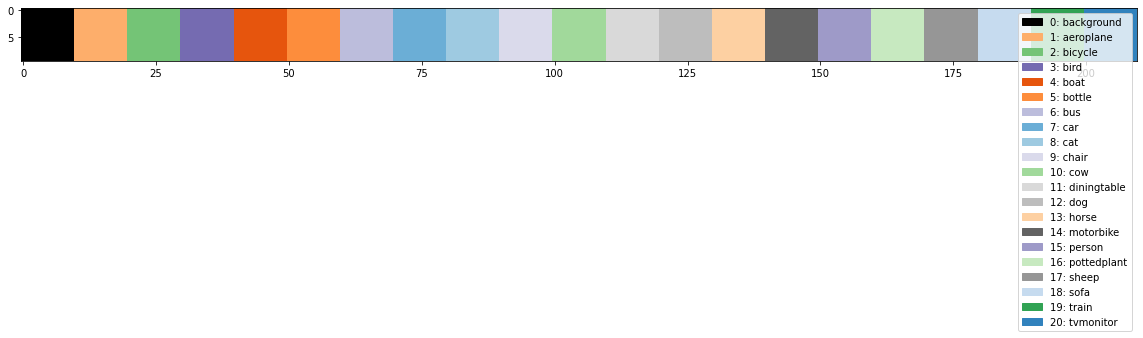

In [ ]:
labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

cmap = plt.cm.get_cmap('tab20c')
colors = (cmap(np.arange(cmap.N)) * 255).astype(np.int)[:, :3].tolist()
np.random.seed(2020)
np.random.shuffle(colors)
colors.insert(0, [0, 0, 0]) # background color must be black
colors = np.array(colors, dtype=np.uint8)

palette_map = np.empty((10, 0, 3), dtype=np.uint8)
legend = []

for i in range(21):
    legend.append(mpatches.Patch(color=np.array(colors[i]) / 255., label='%d: %s' % (i, labels[i])))
    c = np.full((10, 10, 3), colors[i], dtype=np.uint8)
    palette_map = np.concatenate([palette_map, c], axis=1)

plt.figure(figsize=(20, 2))
plt.legend(handles=legend)
plt.imshow(palette_map)

# Segment Function

In [ ]:
def segment(net, img):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    output = model(input_batch)['out'][0] # (21, height, width)

    output_predictions = output.argmax(0).byte().cpu().numpy() # (height, width) 

    r = Image.fromarray(output_predictions).resize((img.shape[1], img.shape[0]))
    r.putpalette(colors)

    return r, output_predictions

# Result

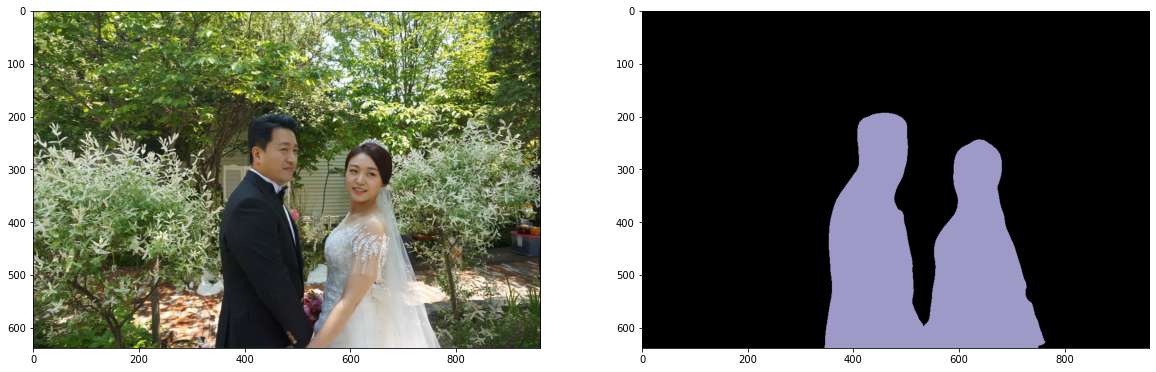

In [ ]:
img = np.array(Image.open('/content/shin_ marriage.jpg'))

fg_h, fg_w, _ = img.shape

segment_map, pred = segment(model, img)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(segment_map)

# Load Background Image and Resize
- make same size as foreground

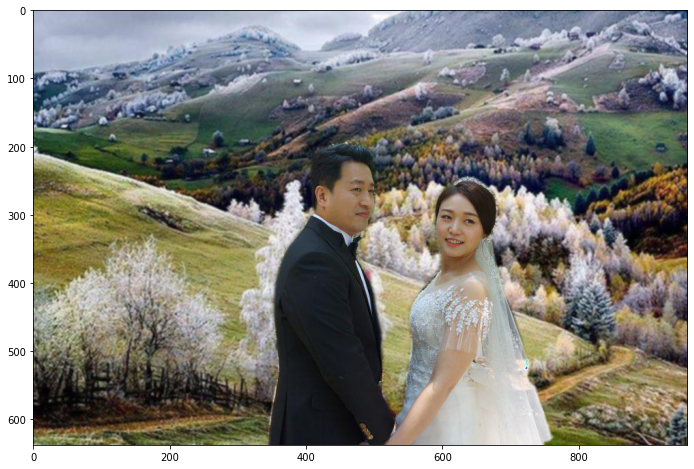

In [ ]:
background = np.array(Image.open('/content/shin_marriage_bg.jpg'))

bg_h, bg_w, _ = background.shape

# fit to fg width
background = cv2.resize(background, dsize=(fg_w, int(fg_w * bg_h / bg_w)))

bg_h, bg_w, _ = background.shape

margin = (bg_h - fg_h) // 2

if margin > 0:
    background = background[margin:-margin, :, :]
else:
    background = cv2.copyMakeBorder(background, top=abs(margin), bottom=abs(margin), left=0, right=0, borderType=cv2.BORDER_REPLICATE)

# final resize
background = cv2.resize(background, dsize=(fg_w, fg_h))

plt.figure(figsize=(12, 8))
plt.imshow(background)

# Separate Foreground and Background

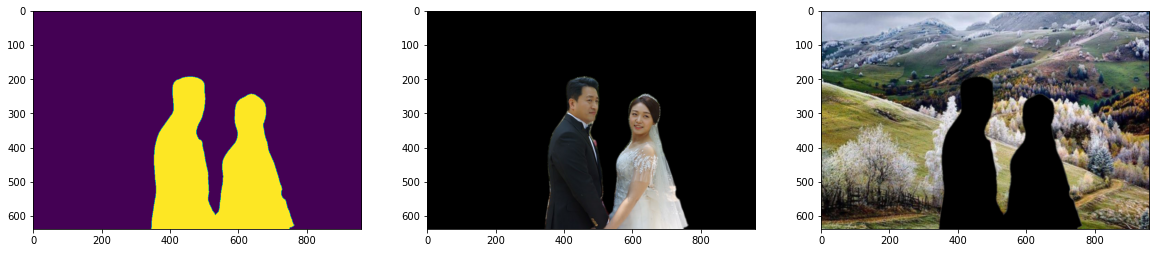

In [ ]:
mask = (pred == 15).astype(float) * 255 # 15: person
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)

alpha = alpha / 255. # (height, width)
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)

foreground = cv2.multiply(alpha, img.astype(float))
background = cv2.multiply(1. - alpha, background.astype(float))  

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(mask)
axes[1].imshow(foreground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))

# Result

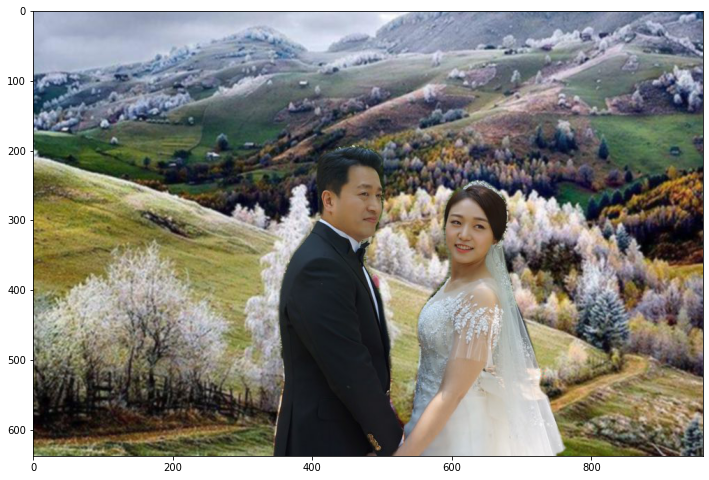

In [ ]:
result = cv2.add(foreground, background).astype(np.uint8)

Image.fromarray(result).save('imgs/result.jpg')

plt.figure(figsize=(12, 12))
plt.imshow(result)

# Blur Background

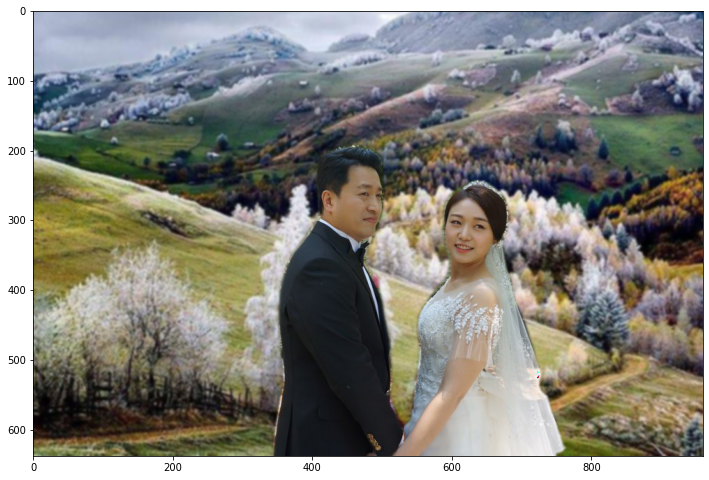

In [ ]:
blurred_background = cv2.GaussianBlur(background, (5, 5), 0).astype(float)

bluured_result = cv2.add(foreground, blurred_background).astype(np.uint8)

Image.fromarray(bluured_result).save('imgs/result_blurred.jpg')

plt.figure(figsize=(12, 12))
plt.imshow(bluured_result)

# Grayscale Background

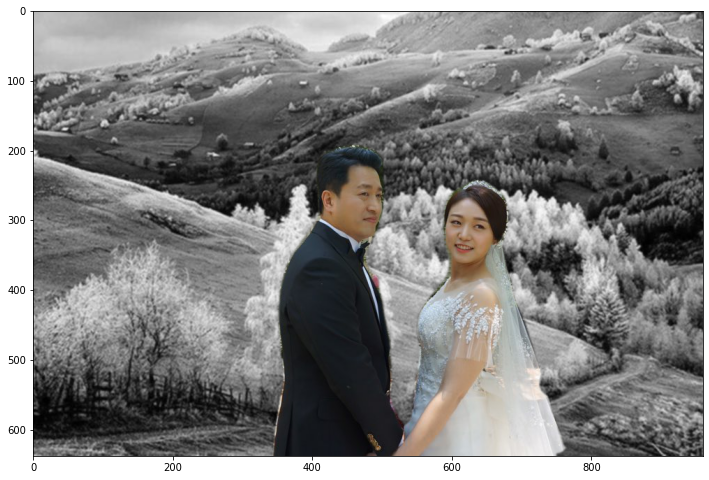

In [ ]:
gray_background = cv2.cvtColor(background.astype(np.uint8), cv2.COLOR_BGR2GRAY)
gray_background = cv2.cvtColor(gray_background, cv2.COLOR_GRAY2BGR).astype(float)

gray_result = cv2.add(foreground, gray_background).astype(np.uint8)

Image.fromarray(gray_result).save('imgs/result_gray.jpg')

plt.figure(figsize=(12, 12))
plt.imshow(gray_result)

# Other Result

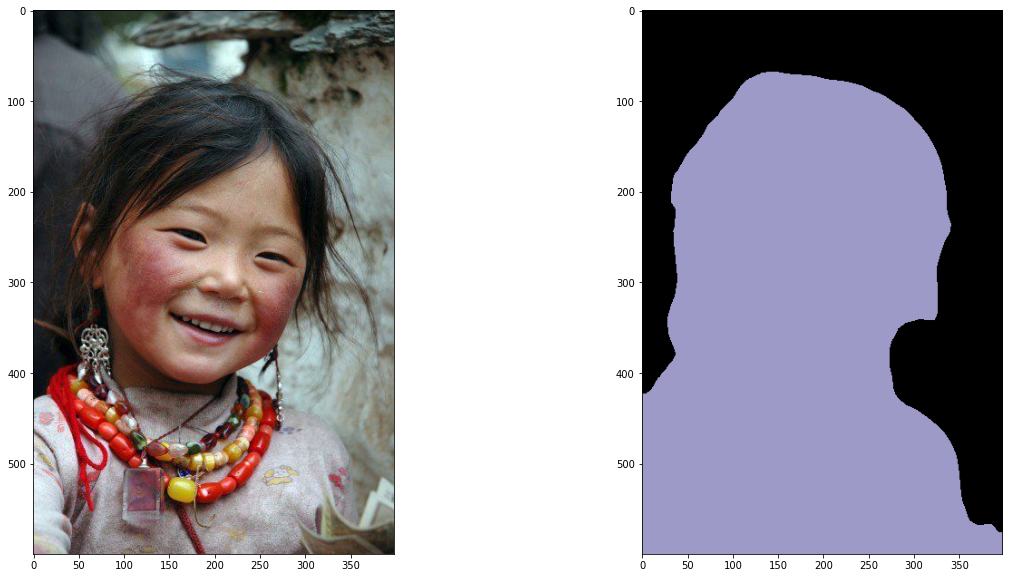

In [ ]:
img = np.array(Image.open('/content/content/child.jpg'))

fg_h, fg_w, _ = img.shape

segment_map, pred = segment(model, img)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(segment_map)

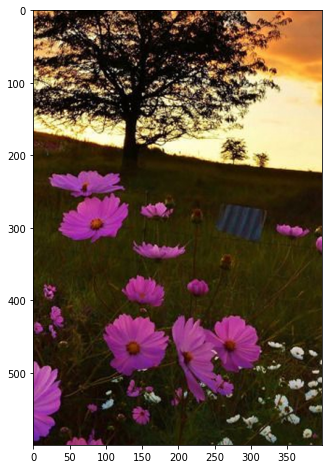

In [ ]:
background = np.array(Image.open('/content/imgs/child_bg.jpg'))

bg_h, bg_w, _ = background.shape

# fit to fg width
background = cv2.resize(background, dsize=(fg_w, int(fg_w * bg_h / bg_w)))

bg_h, bg_w, _ = background.shape

margin = (bg_h - fg_h) // 2

if margin > 0:
    background = background[margin:-margin, :, :]
else:
    background = cv2.copyMakeBorder(background, top=abs(margin), bottom=abs(margin), left=0, right=0, borderType=cv2.BORDER_REPLICATE)

# final resize
background = cv2.resize(background, dsize=(fg_w, fg_h))

plt.figure(figsize=(12, 8))
plt.imshow(background)

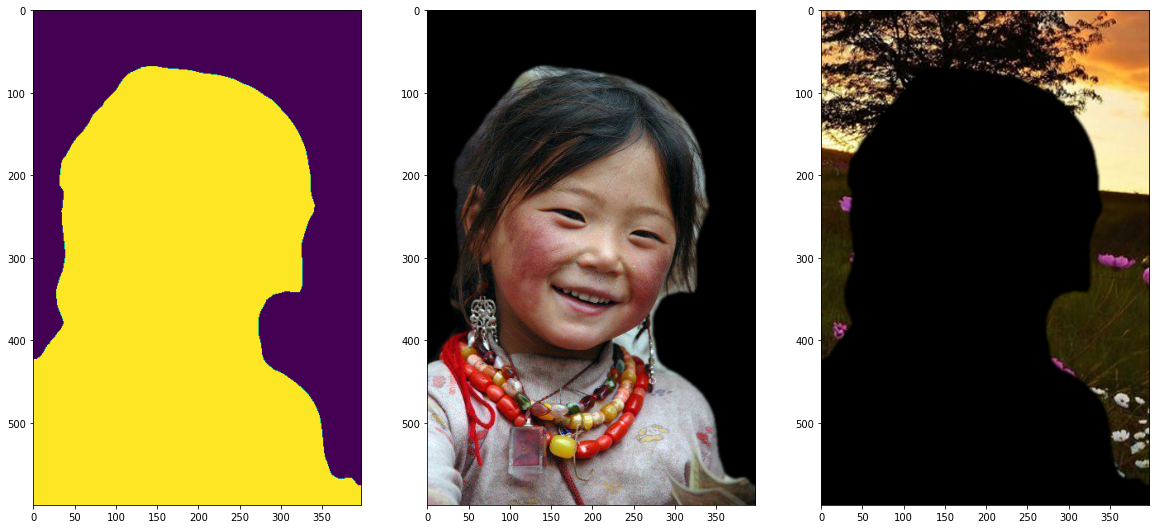

In [ ]:
mask = (pred == 15).astype(float) * 255 # 15: person
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)

alpha = alpha / 255. # (height, width)
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)

foreground = cv2.multiply(alpha, img.astype(float))
background = cv2.multiply(1. - alpha, background.astype(float))  

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(mask)
axes[1].imshow(foreground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))

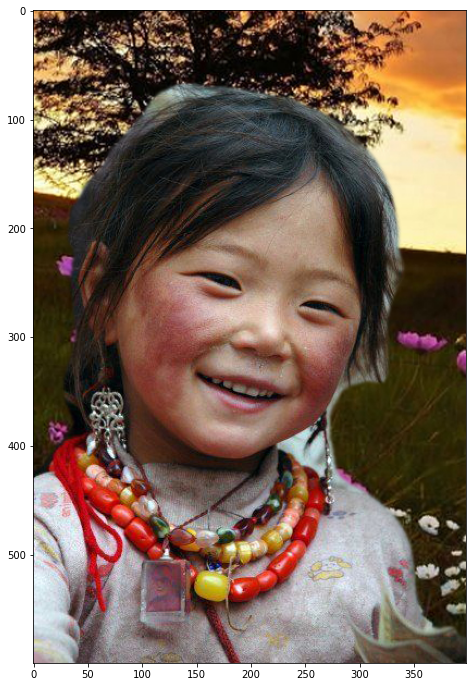

In [ ]:
result = cv2.add(foreground, background).astype(np.uint8)

plt.figure(figsize=(12, 12))
plt.imshow(result)

# Add Birds

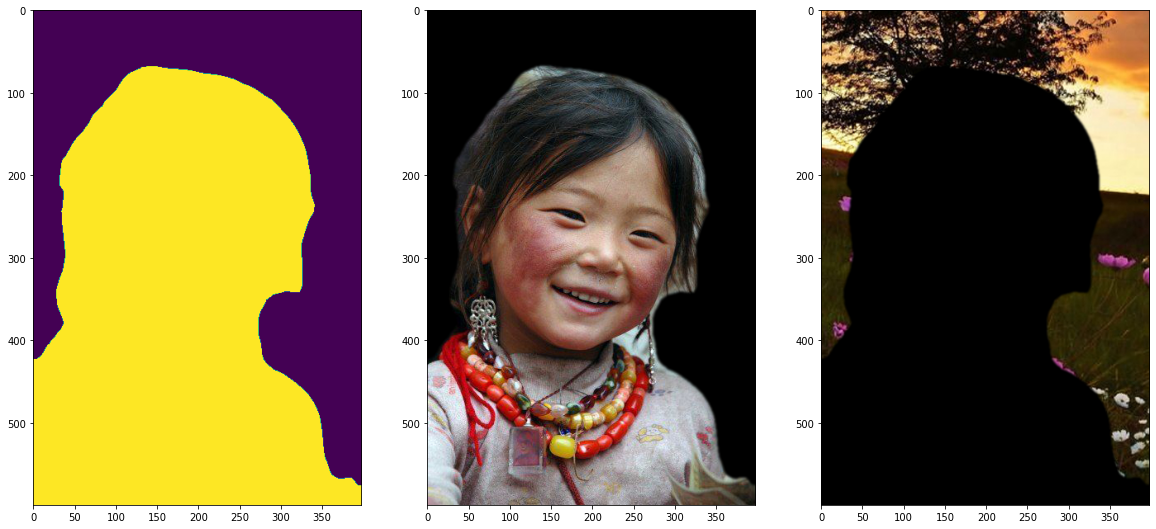

In [ ]:
mask = ((pred == 15) | (pred == 3)).astype(float) * 255 # 15: person, 3: bird
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)

alpha = alpha / 255. # (height, width)
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)

foreground = cv2.multiply(alpha, img.astype(float))
background = cv2.multiply(1. - alpha, background.astype(float))  

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(mask)
axes[1].imshow(foreground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))

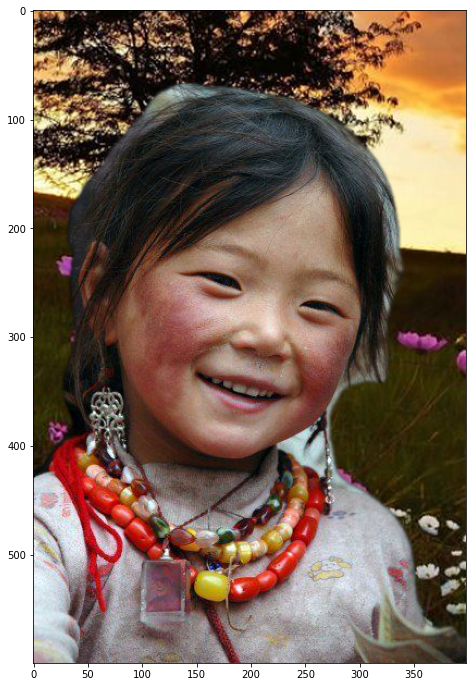

In [ ]:
result = cv2.add(foreground, background).astype(np.uint8)

plt.figure(figsize=(12, 12))
plt.imshow(result)